In [1]:
import pandas as pd
import seaborn as sns
import re
import os
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud
from collections import Counter
from tqdm.auto import tqdm

c:\Users\nguye\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_excel( "data/data_final.xlsx")
df.head()

,Unnamed: 0,old_data,label
0,0,"Shop giao sản phẩm đã qua sử dụng , không hài ...",0
1,1,"Đóng gói cẩn thận, sp mới và nhỏ gọn. Rất hài ...",4
2,2,"Sản phẩm nhỏ gọn, giao hàng rất nhanh.",1
3,3,sản phẩm rất chuẩn so vs quảng cáo.,1
4,4,Nhỏ gọn gê,1


In [3]:
# Bỏ cột 'Unnamed: 0' nếu không cần thiết
df = df.drop(columns=['Unnamed: 0'])
df.head()

,old_data,label
0,"Shop giao sản phẩm đã qua sử dụng , không hài ...",0
1,"Đóng gói cẩn thận, sp mới và nhỏ gọn. Rất hài ...",4
2,"Sản phẩm nhỏ gọn, giao hàng rất nhanh.",1
3,sản phẩm rất chuẩn so vs quảng cáo.,1
4,Nhỏ gọn gê,1


In [4]:
df.shape

(26911, 2)

In [5]:
# Xử lý dữ liệu văn bản trong cột 'old_data'
def clean_text(text):
    # Loại bỏ ký tự đặc biệt, dấu câu và chuyển về chữ thường
    text = text.str.replace(r'[^\w\s]', '', regex=True)  # Loại bỏ ký tự đặc biệt
    text = text.str.lower()  # Chuyển về chữ thường
    return text

df['old_data'] = clean_text(df['old_data'])

### Xử lí viết tắt

In [6]:
folder_path = 'Mapping'
def load_viet_tat_dict(folder_path):
    """Đọc dữ liệu từ các file trong folder và tạo từ điển viết tắt"""
    viet_tat_dict = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as f:
                for line in f:
                    viet_tat, day_du = line.strip().split('#')
                    viet_tat_dict[viet_tat] = day_du
    return viet_tat_dict

# Tạo từ điển viết tắt từ các file
viet_tat_dict = load_viet_tat_dict(folder_path)

In [ ]:
# Để tqdm hoạt động với pandas .apply()
tqdm.pandas()

# Hàm thay thế viết tắt bằng từ đầy đủ
def replace_viet_tat(text, viet_tat_dict):
    # Duyệt qua từng từ viết tắt trong từ điển và thay thế
    for viet_tat, day_du in viet_tat_dict.items():
        # Thoát các ký tự đặc biệt trong từ viết tắt
        viet_tat_escaped = re.escape(viet_tat)
        # Sử dụng regex để tìm từ chính xác (tránh thay thế nhầm trong các từ lớn hơn)
        text = re.sub(r'\b' + viet_tat_escaped + r'\b', day_du, text)
    return text

# Sử dụng tqdm để theo dõi quá trình xử lý dữ liệu
df['old_data'] = df['old_data'].progress_apply(lambda x: replace_viet_tat(x, viet_tat_dict))

 45%|████▍     | 12106/26911 [28:50<58:21:51, 14.19s/it]

In [25]:
df.head()

,old_data,label
0,shop giao sản phẩm đã qua sử dụng không hài l...,0
1,đóng gói cẩn thận sư phạm mới và nhỏ gọn rất h...,4
2,sản phẩm nhỏ gọn giao hàng rất nhanh,1
3,sản phẩm rất chuẩn so vs quảng cáo,1
4,nhỏ gọn gê,1


In [28]:
df.to_csv('data/output.csv', index=False, encoding='utf-8-sig')
df_new = pd.read_csv('data/output.csv')

# Trực quan hóa

#Biểu đồ tần số xuất hiện của các từ

## Biểu đồ phân phối của các label

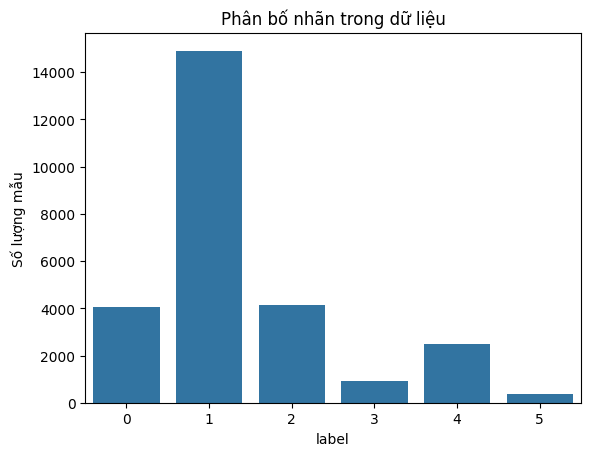

In [29]:
# Đếm số lượng mẫu cho mỗi label
label_distribution = df_new['label'].value_counts()

# Vẽ biểu đồ bar
sns.barplot(x=label_distribution.index, y=label_distribution.values)
plt.gca().set_ylabel('Số lượng mẫu')
plt.gca().set_xlabel('label')
plt.title('Phân bố nhãn trong dữ liệu')
plt.show()

### =>  Label 1 chiếm phần lớn, trong khi label 3 và 5 chiếm khá ít

### Cân bằng lại các mẫu trong mỗi label

Trích xuất đặt trưng TF-IDF

In [30]:
X = df_new['old_data']  # Văn bản
y = df_new['label']     # Nhãn

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sử dụng TfidfVectorizer để chuyển đổi văn bản thành vector số
tfidf = TfidfVectorizer(max_features=1000)  # max_features là số lượng từ đặc trưng tối đa
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

Sinh thêm dữ liệu bằng SMOTE

In [31]:
# SMOTE cho oversampling
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_tfidf, y_train)

# Kiểm tra phân bố nhãn sau khi sử dụng SMOTE
print("Phân bố nhãn sau khi sử dụng SMOTE:")
print(y_smote.value_counts())

Phân bố nhãn sau khi sử dụng SMOTE:
label
2    11879
1    11879
0    11879
4    11879
3    11879
5    11879
Name: count, dtype: int64


Biều đồ

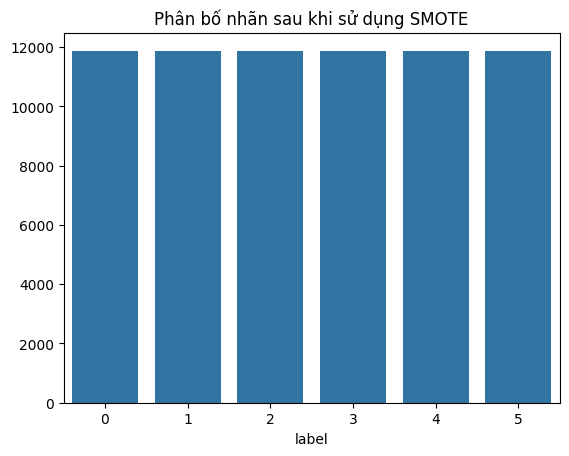

In [32]:
# Vẽ biểu đồ phân bố sau khi oversampling với SMOTE
sns.barplot(x=y_smote.value_counts().index, y=y_smote.value_counts().values)
plt.title('Phân bố nhãn sau khi sử dụng SMOTE')
plt.show()

In [33]:
# Cần phải sử dụng tfidf.inverse_transform để lấy lại văn bản từ vector
X_smote_text = tfidf.inverse_transform(X_smote)

# Tạo DataFrame từ dữ liệu đã cân bằng
df_smote = pd.DataFrame({
    'old_data': [' '.join(text) for text in X_smote_text],
    'label': y_smote
})

print(df_smote.head())

                                            old_data  label
0  ngày lần hai nhất ít định xác se mua bạn nếu o...      2
1  đáng rất giao khi trước kiểm khách cho gửi tin...      1
2  rồi muốn quá xấu thấy về mới không hàng bảo tg...      0
3  gạo bát tiền đồng xứng gần siêu còn đep chụp t...      1
4    em bán luôn người khó thoại điện xài mà lớn cho      0


In [36]:
df_smote.to_csv('data/df_smote.csv')
df_smote = pd.read_csv('data/df_smote.csv')

In [37]:
df_smote.shape

(71274, 4)

## Phân bố từ trong câu

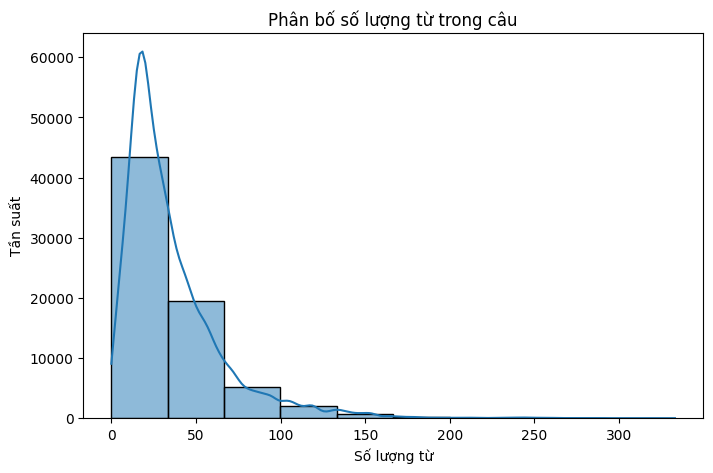

In [42]:
# Kiểm tra và thay thế NaN bằng chuỗi rỗng
df_smote['old_data'] = df_smote['old_data'].fillna('')

# Tính số lượng từ trong mỗi câu
df_smote['word_count'] = df_smote['old_data'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

# Vẽ biểu đồ phân bố số lượng từ
plt.figure(figsize=(8, 5))
sns.histplot(df_smote['word_count'], bins=10, kde=True)
plt.title('Phân bố số lượng từ trong câu')
plt.xlabel('Số lượng từ')
plt.ylabel('Tần suất')
plt.show()

- Dữ liệu chủ yếu bao gồm các câu ngắn: Phần lớn các câu trong tập dữ liệu có số lượng từ thấp, với nhiều câu có từ 0 đến 50 từ.
- Ít câu dài: Số lượng câu có số lượng từ cao (trên 100 từ) rất ít, điều này có thể cho thấy sự ngắn gọn trong các phản hồi hoặc mô tả sản phẩm trong dữ liệu của bạn.

##Loại bỏ các từ xuất hiện ít hơn 2 lần, và nhiều hơn 1000 lần
### Biểu đồ 20 từ phổ biến trong bộ dữ *liệu*

C:\Users\nguye\AppData\Local\Temp\ipykernel_14260\1181488856.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_word_counts.head(20), x='count', y='word', palette='viridis')


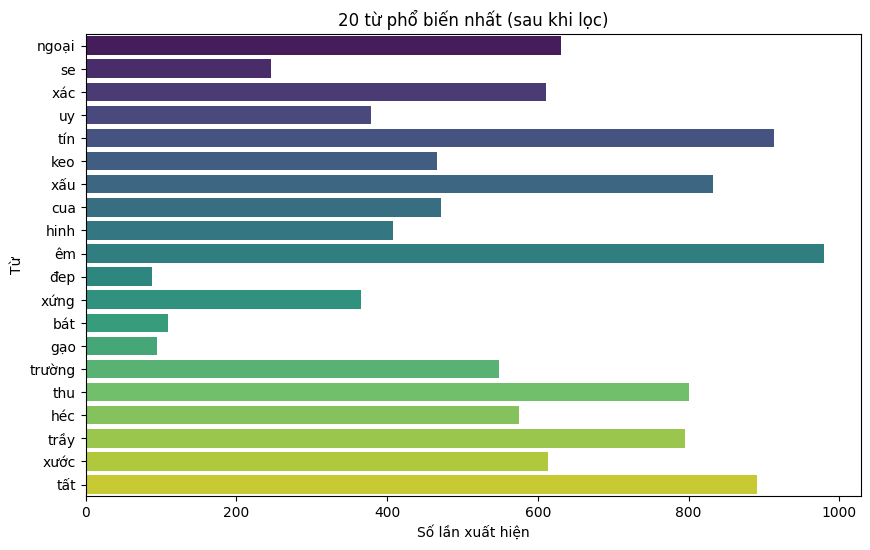

In [43]:
# Tạo danh sách từ từ tất cả các câu
all_words = ' '.join(df_smote['old_data']).lower()  # Chuyển thành chữ thường
words = re.findall(r'\b\w+\b', all_words)  # Tìm tất cả các từ

# Đếm số lần xuất hiện của từng từ
word_counts = Counter(words)

# Chuyển kết quả thành DataFrame
word_counts_df = pd.DataFrame(word_counts.items(), columns=['word', 'count'])

# Lọc từ xuất hiện ít hơn 2 lần và nhiều hơn 1000 lần
filtered_word_counts = word_counts_df[(word_counts_df['count'] >= 2) & (word_counts_df['count'] <= 1000)]

# Tạo danh sách các từ cần xóa
words_to_remove = set(filtered_word_counts['word'])

# Xóa các từ không mong muốn khỏi cột 'old_data'
df_smote['cleaned_old_data'] = df_smote['old_data'].apply(
    lambda x: ' '.join(word for word in x.split() if word.lower() not in words_to_remove)
)

# Vẽ biểu đồ số lượng từ
plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_word_counts.head(20), x='count', y='word', palette='viridis')
plt.title('20 từ phổ biến nhất (sau khi lọc)')
plt.xlabel('Số lần xuất hiện')
plt.ylabel('Từ')
plt.show()

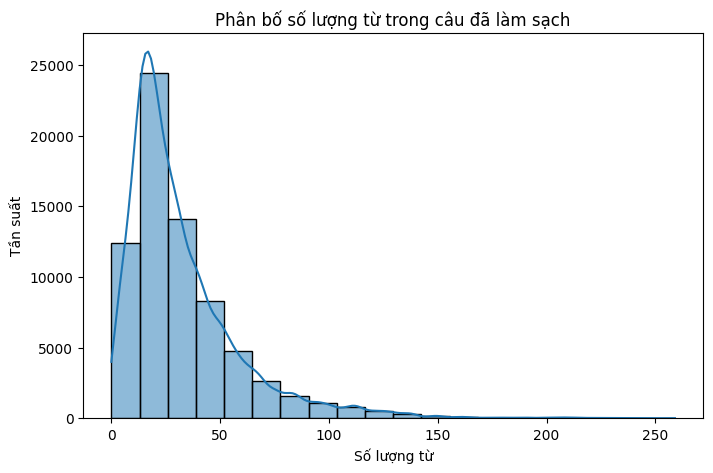

In [44]:
df_smote['cleaned_word_count'] = df_smote['cleaned_old_data'].apply(lambda x: len(x.split()))

# Vẽ biểu đồ phân bố số lượng từ
plt.figure(figsize=(8, 5))
sns.histplot(df_smote['cleaned_word_count'], bins=20, kde=True)
plt.title('Phân bố số lượng từ trong câu đã làm sạch')
plt.xlabel('Số lượng từ')
plt.ylabel('Tần suất')
plt.show()

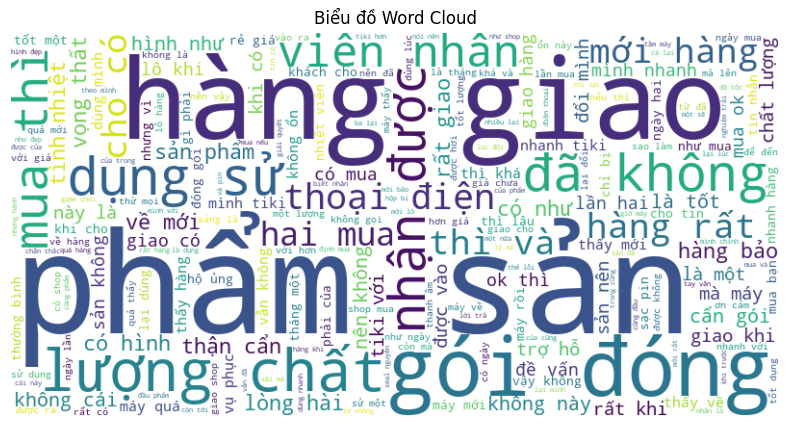

In [45]:
text = ' '.join(df_smote['cleaned_old_data'])

# Tạo đối tượng WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Vẽ biểu đồ Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Tắt trục
plt.title('Biểu đồ Word Cloud')
plt.show()

C:\Users\nguye\AppData\Local\Temp\ipykernel_14260\1534626379.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_smote, x='label', palette='viridis')


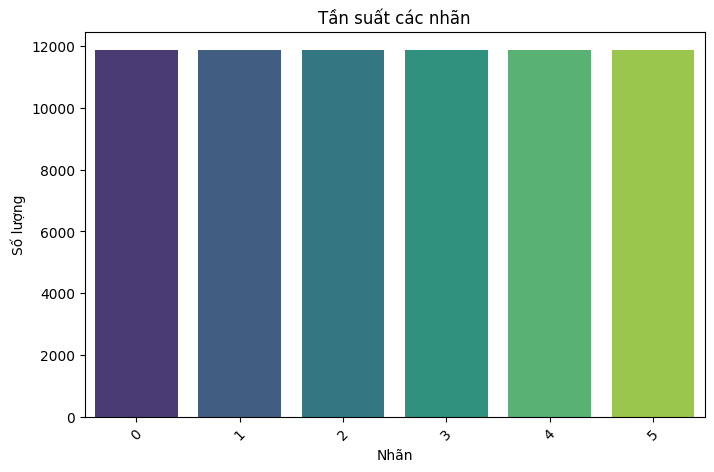

In [46]:
# Vẽ biểu đồ tần suất của các nhãn
plt.figure(figsize=(8, 5))
sns.countplot(data=df_smote, x='label', palette='viridis')
plt.title('Tần suất các nhãn')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng')
plt.xticks(rotation=45)  # Xoay nhãn cho dễ đọc
plt.show()

In [47]:
# Hiển thị DataFrame với cột 'cleaned_old_data'
df_final = df_smote[['cleaned_old_data', 'label']]
df_final.head()

,cleaned_old_data,label
0,trừ phần pin yếu và sạc khá lâu thì mọi thứ đề...,2
1,shop ốp đẹp như hình có nhắn tin gửi cho khách...,1
2,mua có khi dán tại tgdd bảo hàng lô mới về thấ...,0
3,pin có đáng quá máy tầm samsung giờ cấu cao lớ...,1
4,cho lớn mà xài điện thoại khó người luôn bán em,0


In [ ]:
df_final.to_csv('df_final.csv')